In [3]:
# !pip install textblob vaderSentiment scikit-learn

In [7]:
# !pip install vaderSentiment

### Load data

In [75]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

df = pd.read_csv('../data/all_banks_reviews_cleaned.csv')

### Sentiment Analysis using TextBlob

In [76]:
def textblob_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.05:
        return 'positive'
    elif polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['review'].apply(textblob_sentiment)

### Sentiment Analysis using VADER

In [77]:
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = vader.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['review'].apply(vader_sentiment)


### Compare the Two Methods

In [79]:
sentiment_counts = df[['textblob_sentiment', 'vader_sentiment', 'bank']] \
    .groupby('bank') \
    .agg(lambda x: x.value_counts().to_dict())


display(sentiment_counts)

def extract_keywords(data, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = vectorizer.fit_transform(data)
    return vectorizer.get_feature_names_out()[:top_n]


,textblob_sentiment,vader_sentiment
bank,,
Bank of Abyssinia,"{'positive': 466, 'neutral': 374, 'negative': ...","{'positive': 479, 'neutral': 316, 'negative': ..."
Commercial Bank of Ethiopia,"{'positive': 662, 'neutral': 272, 'negative': 66}","{'positive': 682, 'neutral': 222, 'negative': 96}"
Dashen Bank,"{'positive': 333, 'neutral': 88, 'negative': 28}","{'positive': 333, 'neutral': 90, 'negative': 26}"


### Sentiment using distilbert-base-uncased-finetuned-sst-2-english

In [80]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from spellchecker import SpellChecker

# Load data
INPUT_FILE = r'..\data\all_banks_reviews_cleaned.csv'
OUTPUT_FILE = r'..\data\all_banks_reviews_with_sentiment.csv'

df = pd.read_csv(INPUT_FILE)

# Spelling correction with caching
spell = SpellChecker()
correction_cache = {}

def correct_spelling(text):
    corrected = []
    for word in str(text).split():
        if word in correction_cache:
            corrected_word = correction_cache[word]
        else:
            corrected_word = spell.correction(word)
            correction_cache[word] = corrected_word
        corrected.append(corrected_word if corrected_word else word)
    return " ".join(corrected)

df['review_corrected'] = df['review'].astype(str).apply(correct_spelling)

# Load DistilBERT sentiment model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"
)

# batch sentiment analysis
batch_size = 32
predictions = []

for i in tqdm(range(0, len(df), batch_size)):
    batch = df['review_corrected'].iloc[i:i + batch_size].tolist()
    preds = sentiment_pipeline(batch)
    predictions.extend(preds)

df['bert_sentiment'] = [p['label'].lower() for p in predictions]
df['sentiment_score'] = [p['score'] for p in predictions]

# Adjust sentiment using star rating
def adjust_sentiment(label, rating):
    if rating >= 4 and label == 'negative':
        return 'positive'
    elif rating <= 2 and label == 'positive':
        return 'negative'
    elif rating == 3:
        return 'neutral'
    return label

# Adjusting sentiment based on rating
df['adjusted_sentiment'] = [
    adjust_sentiment(label, rating) 
    for label, rating in zip(df['bert_sentiment'], df['rating'])
]

df.to_csv(OUTPUT_FILE, index=False)
print(f" Sentiment analysis complete and saved to: {OUTPUT_FILE}")


Device set to use cpu
100%|██████████| 78/78 [01:13<00:00,  1.06it/s]

 Sentiment analysis complete and saved to: ..\data\all_banks_reviews_with_sentiment.csv


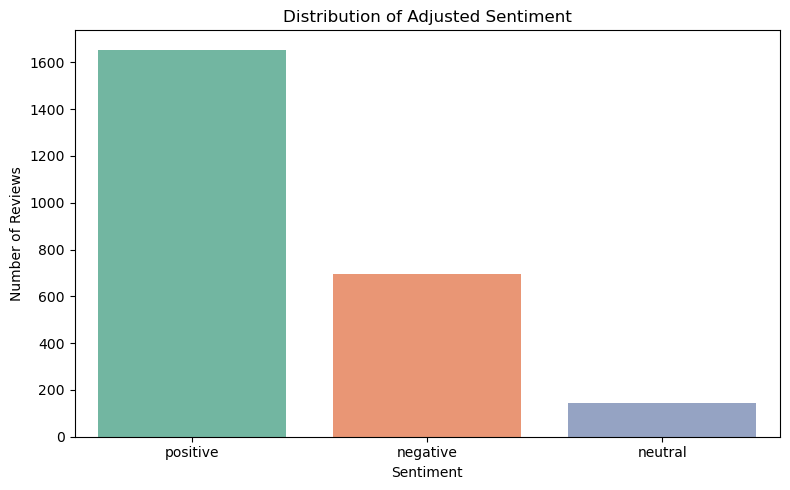

<Figure size 1000x600 with 0 Axes>

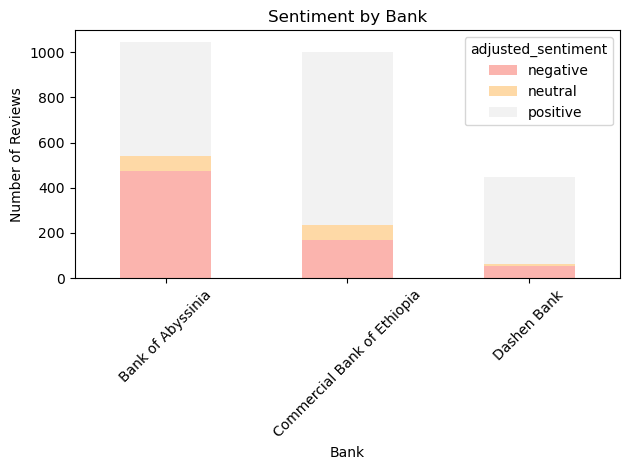

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution (Bar Plot)
plt.figure(figsize=(8, 5))
sns.countplot(x='adjusted_sentiment', data=df, palette='Set2')
plt.title("Distribution of Adjusted Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

# Sentiment by Bank (Stacked Bar Plot)
plt.figure(figsize=(10, 6))
sentiment_by_bank = df.groupby(['bank', 'adjusted_sentiment']).size().unstack().fillna(0)
sentiment_by_bank.plot(kind='bar', stacked=True, colormap='Pastel1')
plt.title("Sentiment by Bank")
plt.ylabel("Number of Reviews")
plt.xlabel("Bank")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Thematic analysis

In [4]:
# !pip install "numpy<2.0"

In [82]:
# import libraries
import pandas as pd
import spacy
from collections import Counter, defaultdict
import string

In [83]:
# Load data
import pandas as pd
df = pd.read_csv('../data/all_banks_reviews_with_sentiment.csv')

In [84]:
def preprocess(text):
    doc = nlp(str(text).lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and token.lemma_ not in string.punctuation
    ]
    return tokens

df["tokens"] = df["review_corrected"].apply(preprocess)


In [85]:
def get_bigrams(tokens):
    return [f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens)-1)]

df["bigrams"] = df["tokens"].apply(get_bigrams)

In [86]:
theme_mapping = {
    "Account Access Issues": [
        "login", "password", "sign", "signin", "blocked", "account locked", "login issue"
    ],
    "Transaction Performance": [
        "slow", "transfer", "fail", "hang", "crash", "timeout", "doesn work", "doesn", "working", "fix", "delay"
    ],
    "User Interface": [
        "design", "layout", "navigation", "responsive", "screen", "ui", "interface", "look", "user friendly"
    ],
    "Customer Support": [
        "support", "response", "help", "contact", "assist", "call", "no response"
    ],
    "Feature Requests": [
        "feature", "add", "option", "update", "new version", "request", "custom"
    ],
    "Positive Feedback": [
        "good", "nice", "best", "wow", "excellent", "great", "amazing", "thank", "happy", "satisfied", "fast", "awesome", "attractive", "just"
    ],
    "App Experience": [
        "mobile", "application", "banking", "ape", "super", "mobile banking", "dash bank", "use", "easy", "ok", "job", "work", "service", "bank", "banking", "finance", "app", "apes", "ethiopia", "boa", "apply"
    ],
    "App Functionality Issues": [
        "bug", "freeze", "crash", "unstable", "hang", "not responding", "force close", "time", "doesn work", "worst"
    ]
}


# Theme matcher using tokens and bigrams 
def map_to_themes(tokens, bigrams):
    all_terms = tokens + bigrams
    matched = set()
    for theme, keywords in theme_mapping.items():
        if any(k in all_terms for k in keywords):
            matched.add(theme)
    return list(matched) if matched else ["Other"]

df["themes"] = df.apply(lambda row: map_to_themes(row["tokens"], row["bigrams"]), axis=1)

# Save results
df["keywords"] = df["tokens"].apply(lambda x: ", ".join(x))
df["identified_themes"] = df["themes"].apply(lambda x: ", ".join(x))

df_output = df[["bank", "review", "adjusted_sentiment", "keywords", "identified_themes"]]

In [87]:
print(df["themes"].explode().value_counts())

themes
App Experience              1268
Positive Feedback           1202
Other                        508
Feature Requests             266
Transaction Performance      241
App Functionality Issues     194
User Interface                89
Customer Support              38
Account Access Issues         37
Name: count, dtype: int64


In [88]:
from collections import Counter

# Count theme frequency per bank
theme_summary = {}

for bank in df['bank'].unique():
    bank_df = df[df['bank'] == bank]
    themes_flat = [theme for sublist in bank_df['themes'] for theme in sublist]
    theme_counts = Counter(themes_flat)
    theme_summary[bank] = theme_counts.items() 


for bank, themes in theme_summary.items():
    print(f"\n {bank}")
    for theme, count in themes:
        print(f"  - {theme}: {count}")



 Commercial Bank of Ethiopia
  - Positive Feedback: 528
  - App Experience: 437
  - User Interface: 24
  - Customer Support: 11
  - Transaction Performance: 75
  - Other: 199
  - Feature Requests: 80
  - App Functionality Issues: 57
  - Account Access Issues: 3

 Bank of Abyssinia
  - App Experience: 563
  - Account Access Issues: 30
  - Positive Feedback: 407
  - Feature Requests: 125
  - App Functionality Issues: 116
  - Transaction Performance: 136
  - Other: 238
  - User Interface: 21
  - Customer Support: 15

 Dashen Bank
  - Customer Support: 12
  - App Experience: 268
  - Positive Feedback: 267
  - User Interface: 44
  - Other: 71
  - Feature Requests: 61
  - Transaction Performance: 30
  - Account Access Issues: 4
  - App Functionality Issues: 21


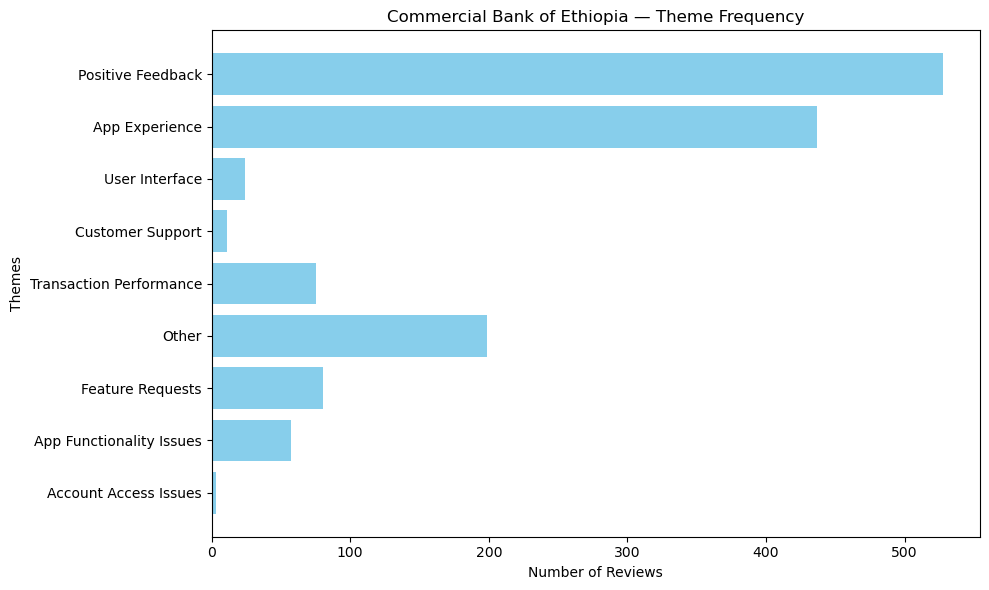

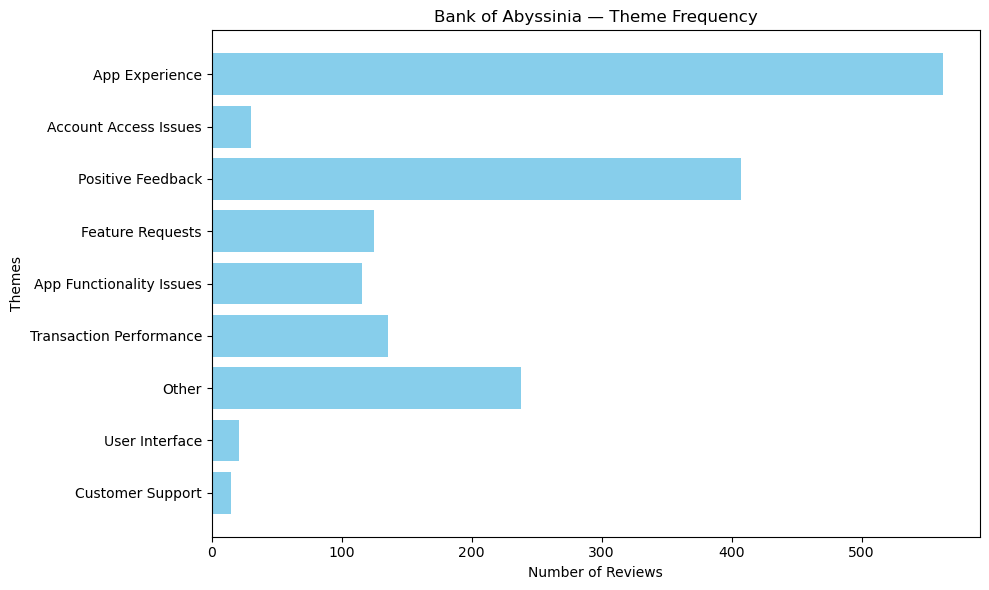

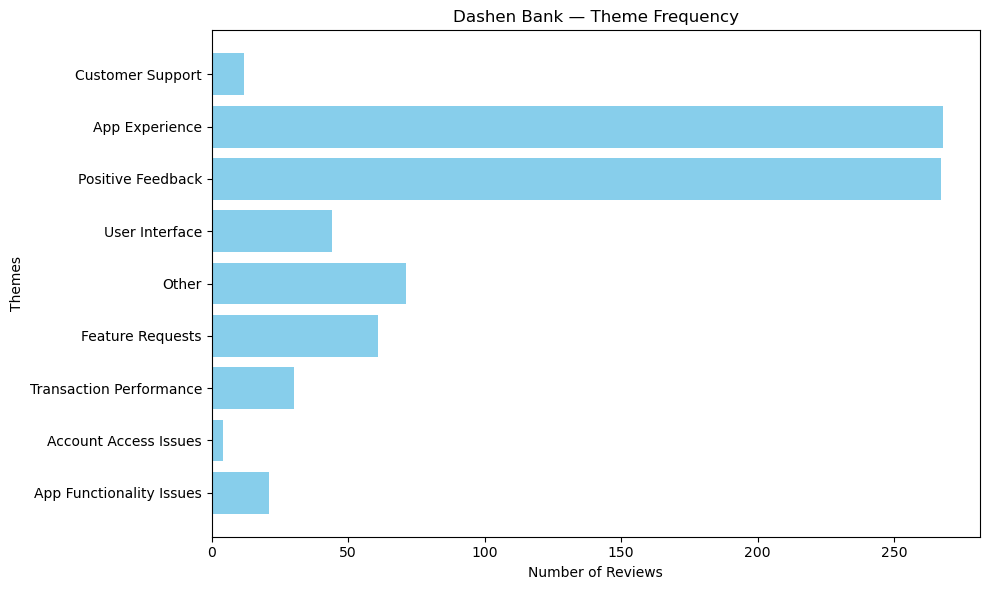

In [89]:
import matplotlib.pyplot as plt
from collections import Counter

# Plot theme frequencies per bank
for bank in df['bank'].unique():
    bank_df = df[df['bank'] == bank]
    themes_flat = [theme for sublist in bank_df['themes'] for theme in sublist]
    theme_counts = Counter(themes_flat)

    # Prepare data for plotting
    labels = list(theme_counts.keys())
    counts = list(theme_counts.values())

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(labels, counts, color='skyblue')
    plt.title(f"{bank} — Theme Frequency")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Themes")
    plt.gca().invert_yaxis()  # Most frequent at top
    plt.tight_layout()
    plt.show()

In [73]:
# Save the output
df_output.to_csv("../data/all_banks_reviews_with_themes.csv", index=False)